In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
#mpl.use('agg')
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(15)
import json
import os
from read_O3_LVK_results import *

In [2]:
inference_data = az.from_netcdf("/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_chi_cost_1000_1500_noReweighting.cdf")

In [4]:
list(inference_data.posterior.keys())

['R20',
 'alpha',
 'ar_chi_std',
 'ar_chi_tau',
 'ar_cost_std',
 'ar_cost_tau',
 'bq',
 'chi_steps_backward',
 'chi_steps_forward',
 'cost_steps_backward',
 'f_chis',
 'f_cost',
 'kappa',
 'ln_f_chi_ref_unscaled',
 'ln_f_cost_ref_unscaled',
 'logR20',
 'log_dmMax',
 'log_dmMin',
 'log_f_peak',
 'logit_ar_chi_tau',
 'logit_ar_cost_tau',
 'logit_log_dmMax',
 'logit_log_dmMin',
 'logit_log_f_peak',
 'logit_mMax',
 'logit_sig_m1',
 'mMax',
 'mMin',
 'min_log_neff',
 'mu_m1',
 'nEff_inj_per_event',
 'sig_m1']

In [5]:
precomputed_data = "stored_chi_cost_data.npy"

if os.path.exists(precomputed_data):
    
    traces = np.load(precomputed_data,allow_pickle=True)[()]
    chis = traces['chis']
    costs = traces['costs']
    f_chis = traces['f_chis']
    f_costs = traces['f_costs']
    R_ref = traces['R_ref']
    f_a01 = traces['f_a01']
    f_cost1 = traces['f_cost1']
    bq = traces['bq']
    alpha = traces['alpha']
    mu_m1 = traces['mu_m1']
    sig_m1 = traces['sig_m1']
    log_f_peak = traces['log_f_peak']
    mMin = traces['mMin']
    mMax = traces['mMax']
    log_dmMin = traces['log_dmMin']
    log_dmMax = traces['log_dmMax']
    
else:

    # Load inference data
    inference_data = az.from_netcdf("/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_chi_cost_1000_1500_noReweighting.cdf")

    # Also extract mass and mass ratio values
    chi_cost_data = np.load('/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_chi_cost_data_1000_1500_noReweighting.npy',allow_pickle=True)[()]
    chi_values = chi_cost_data['chi_allSamples']
    cost_values = chi_cost_data['cost_allSamples']
    
    alpha_values = np.concatenate([
        inference_data.posterior.alpha.values[i,:]
        for i in range(inference_data.posterior.alpha.shape[0])])
    
    mu_m1_values = np.concatenate([
        inference_data.posterior.mu_m1.values[i,:]
        for i in range(inference_data.posterior.mu_m1.shape[0])])
    
    sig_m1_values = np.concatenate([
        inference_data.posterior.sig_m1.values[i,:]
        for i in range(inference_data.posterior.sig_m1.shape[0])])
    
    log_f_peak_values = np.concatenate([
        inference_data.posterior.log_f_peak.values[i,:]
        for i in range(inference_data.posterior.log_f_peak.shape[0])])
    
    mMin_values = np.concatenate([
        inference_data.posterior.mMin.values[i,:]
        for i in range(inference_data.posterior.mMin.shape[0])])
    
    mMax_values = np.concatenate([
        inference_data.posterior.mMax.values[i,:]
        for i in range(inference_data.posterior.mMax.shape[0])])
    
    log_dmMin_values = np.concatenate([
        inference_data.posterior.log_dmMin.values[i,:]
        for i in range(inference_data.posterior.log_dmMin.shape[0])])
    
    log_dmMax_values = np.concatenate([
        inference_data.posterior.log_dmMax.values[i,:]
        for i in range(inference_data.posterior.log_dmMax.shape[0])])
    
    bq_values = np.concatenate([
        inference_data.posterior.bq.values[i,:]
        for i in range(inference_data.posterior.bq.shape[0])])

    chis = chi_values[::100]
    f_chis = np.concatenate([
        inference_data.posterior.f_chis.values[i,:,::100]
        for i in range(inference_data.posterior.f_chis.shape[0])])

    costs = cost_values[::100]
    f_costs = np.concatenate([
        inference_data.posterior.f_cost.values[i,:,::100]
        for i in range(inference_data.posterior.f_cost.shape[0])])

    R_ref = np.concatenate([
        inference_data.posterior.R20.values[i,:]
        for i in range(inference_data.posterior.R20.shape[0])])

    ind_a01 = chi_cost_data['ind_a01']
    f_a01 = np.concatenate([
        inference_data.posterior.f_chis.values[i,:,ind_a01]
        for i in range(inference_data.posterior.f_chis.shape[0])])

    f_cost1 = np.concatenate([
        inference_data.posterior.f_cost.values[i,:,-1]
        for i in range(inference_data.posterior.f_cost.shape[0])])

    traces = {
        'chis':chis,
        'costs':costs,
        'f_chis':f_chis,
        'f_costs':f_costs,
        'R_ref':R_ref,
        'f_a01':f_a01,
        'f_cost1':f_cost1,
        'bq':bq_values,
        'alpha':alpha_values,
        'mu_m1':mu_m1_values,
        'sig_m1':sig_m1_values,
        'log_f_peak':log_f_peak_values,
        'mMin':mMin_values,
        'mMax':mMax_values,
        'log_dmMin':log_dmMin_values,
        'log_dmMax':log_dmMax_values
        }

    np.save('stored_chi_cost_data.npy',traces)

In [3]:
lvk_chi_grid,lvk_cost_grid,lvk_R_chi,lvk_R_cost,lvk_p_chis,lvk_p_costs = get_lvk_componentSpin(500)

/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:68: RuntimeWarning: overflow encountered in exp
  q_smoothing[to_smooth] = 1./(np.exp(delta_m/((Q*M)[to_smooth]-mMin) + delta_m/((Q*M)[to_smooth]-mMin-delta_m))+1.)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:71: RuntimeWarning: divide by zero encountered in power
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:71: RuntimeWarning: invalid value encountered in multiply
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:73: RuntimeWarning: invalid value encountered in true_divide
  p_q_unnormed /= np.trapz(p_q_unnormed,q_grid,axis=0)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3

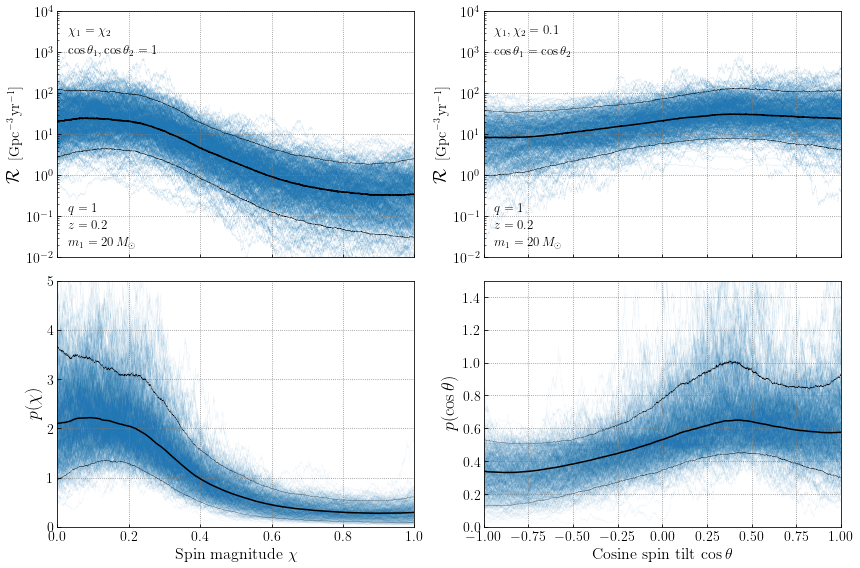

In [6]:
fig = plt.figure(figsize=(12,8))

#########################
ax = fig.add_subplot(221)
ax.set_rasterization_zorder(1)

# Convert to dR/dlnm*dq at m1=20 and q=1
p_q1 = (1.+bq)/(1.-(2./20.)**(1.+bq))
dR_dchi_cost1 = R_ref[:,np.newaxis]*f_cost1[:,np.newaxis]**2*f_chis**2*p_q1[:,np.newaxis]*20.
      
for i in np.random.choice(range(dR_dchi_cost1.shape[0]),size=500,replace=False):                 
    ax.plot(chis,dR_dchi_cost1[i,:],color='#1f78b4',alpha=0.2,lw=0.2,zorder=0)
    
ax.plot(chis,np.median(dR_dchi_cost1,axis=0),color='black')
ax.plot(chis,np.quantile(dR_dchi_cost1,0.05,axis=0),color='black',lw=0.3)
ax.plot(chis,np.quantile(dR_dchi_cost1,0.95,axis=0),color='black',lw=0.3)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(1e-2,1e4)
ax.set_yscale('log')
ax.set_xticklabels([])

ax.text(0.03,0.92,r'$\chi_1 = \chi_2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.84,r'$\cos\theta_1,\cos\theta_2 = 1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.text(0.03,0.20,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.13,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

#########################
ax = fig.add_subplot(222)
ax.set_rasterization_zorder(1)

dR_dcost_a01 = R_ref[:,np.newaxis]*f_a01[:,np.newaxis]**2*f_costs**2*p_q1[:,np.newaxis]*20.
      
for i in np.random.choice(range(dR_dcost_a01.shape[0]),size=500,replace=False):                 
    ax.plot(costs,dR_dcost_a01[i,:],color='#1f78b4',alpha=0.2,lw=0.2,zorder=0)
    
ax.plot(costs,np.median(dR_dcost_a01,axis=0),color='black')
ax.plot(costs,np.quantile(dR_dcost_a01,0.05,axis=0),color='black',lw=0.3)
ax.plot(costs,np.quantile(dR_dcost_a01,0.95,axis=0),color='black',lw=0.3)

ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(1e-2,1e4)
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

ax.text(0.03,0.92,r'$\chi_1,\chi_2=0.1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.84,r'$\cos\theta_1=\cos\theta_2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.text(0.03,0.20,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.13,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

#########################
ax = fig.add_subplot(223)
ax.set_rasterization_zorder(1)

p_chi = f_chis/np.trapz(f_chis,chis)[:,np.newaxis]

for i in np.random.choice(range(p_chi.shape[0]),size=500,replace=False):                 
    ax.plot(chis,p_chi[i,:],color='#1f78b4',alpha=0.2,lw=0.1,zorder=0)
    
ax.plot(chis,np.mean(p_chi,axis=0),color='black')
ax.plot(chis,np.quantile(p_chi,0.05,axis=0),color='black',lw=0.2)
ax.plot(chis,np.quantile(p_chi,0.95,axis=0),color='black',lw=0.2)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,5)
#ax.set_yscale('log')

ax.set_xlabel('Spin magnitude $\chi$',fontsize=16)
ax.set_ylabel(r'$p(\chi)$',fontsize=18)

#########################
ax = fig.add_subplot(224)
ax.set_rasterization_zorder(1)

p_cost = f_costs/np.trapz(f_costs,costs)[:,np.newaxis]
      
for i in np.random.choice(range(p_cost.shape[0]),size=500,replace=False):                 
    ax.plot(costs,p_cost[i,:],color='#1f78b4',alpha=0.2,lw=0.1,zorder=0)
    
ax.plot(costs,np.mean(p_cost,axis=0),color='black')
ax.plot(costs,np.quantile(p_cost,0.05,axis=0),color='black',lw=0.2)
ax.plot(costs,np.quantile(p_cost,0.95,axis=0),color='black',lw=0.2)

ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1.5)
#ax.set_yticklabels([])

ax.set_xlabel('Cosine spin tilt $\cos \\theta$',fontsize=16)
ax.set_ylabel(r'$p(\cos\theta)$',fontsize=18)

plt.tight_layout()
plt.savefig('chi_cost.pdf',bbox_inches='tight',dpi=200)
plt.show()

In [25]:
ind_a00 = 0
ind_a02 = np.argmin(np.abs(chis-0.2))
ind_a06 = np.argmin(np.abs(chis-0.6))
ind_a08 = np.argmin(np.abs(chis-0.8))

R_a00_to_a02 = np.trapz(dR_dchi_cost1[:,ind_a00:ind_a02],chis[ind_a00:ind_a02],axis=1)/\
    np.trapz(np.ones(chis[ind_a00:ind_a02].size),chis[ind_a00:ind_a02])
R_a06_to_a08 = np.trapz(dR_dchi_cost1[:,ind_a06:ind_a08],chis[ind_a06:ind_a08],axis=1)/\
    np.trapz(np.ones(chis[ind_a06:ind_a08].size),chis[ind_a06:ind_a08])

rate_ratio = R_a06_to_a08/R_a00_to_a02
rate_ratio[rate_ratio>1]

array([], dtype=float64)

0.8966666666666666


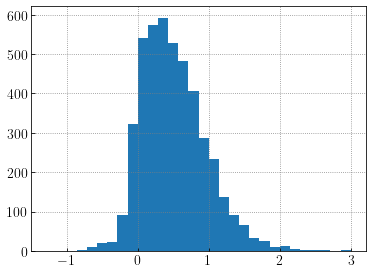

In [32]:
ind_cost_n10 = 0
ind_cost_n09 = np.argmin(np.abs(costs+0.9))
ind_cost_09 = np.argmin(np.abs(costs-0.9))
ind_cost_10 = np.argmin(np.abs(costs-1.0))

R_cost_n10_to_n09 = np.trapz(dR_dcost_a01[:,ind_cost_n10:ind_cost_n09],costs[ind_cost_n10:ind_cost_n09],axis=1)/\
    np.trapz(np.ones(costs[ind_cost_n10:ind_cost_n09].size),costs[ind_cost_n10:ind_cost_n09])
R_cost_09_to_10 = np.trapz(dR_dcost_a01[:,ind_cost_09:ind_cost_10],costs[ind_cost_09:ind_cost_10],axis=1)/\
    np.trapz(np.ones(costs[ind_cost_09:ind_cost_10].size),costs[ind_cost_09:ind_cost_10])

rate_ratio = R_cost_09_to_10/R_cost_n10_to_n09

print(rate_ratio[rate_ratio>1].size/rate_ratio.size)

plt.hist(np.log10(rate_ratio),bins=30)
plt.show()

0.5275555555555556
0.6933333333333334
0.37533333333333335


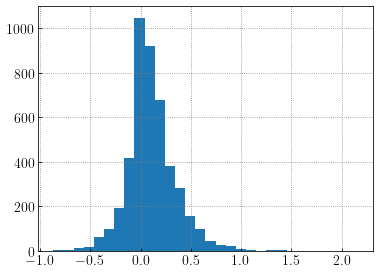

In [43]:
ind_cost_05 = np.argmin(np.abs(costs-0.05))
ind_cost_15 = np.argmin(np.abs(costs-0.15))
ind_cost_25 = np.argmin(np.abs(costs-0.25))
ind_cost_50 = np.argmin(np.abs(costs-0.5))
ind_cost_60 = np.argmin(np.abs(costs-0.6))
ind_cost_70 = np.argmin(np.abs(costs-0.7))

R_cost_05_to_15 = np.trapz(dR_dcost_a01[:,ind_cost_05:ind_cost_15],costs[ind_cost_05:ind_cost_15],axis=1)/\
    np.trapz(np.ones(costs[ind_cost_05:ind_cost_15].size),costs[ind_cost_05:ind_cost_15])
R_cost_25_to_50 = np.trapz(dR_dcost_a01[:,ind_cost_25:ind_cost_50],costs[ind_cost_25:ind_cost_50],axis=1)/\
    np.trapz(np.ones(costs[ind_cost_25:ind_cost_50].size),costs[ind_cost_25:ind_cost_50])
R_cost_60_to_70 = np.trapz(dR_dcost_a01[:,ind_cost_60:ind_cost_70],costs[ind_cost_60:ind_cost_70],axis=1)/\
    np.trapz(np.ones(costs[ind_cost_60:ind_cost_70].size),costs[ind_cost_60:ind_cost_70])

rate_ratio_low = R_cost_25_to_50/R_cost_05_to_15
rate_ratio_high = R_cost_25_to_50/R_cost_60_to_70

print(rate_ratio_low[(rate_ratio_high>1)].size/rate_ratio_low.size)
print(rate_ratio_low[(rate_ratio_low>1)].size/rate_ratio_low.size)
print(rate_ratio_low[(rate_ratio_low>1)*(rate_ratio_high>1)].size/rate_ratio_low.size)

plt.hist(np.log10(rate_ratio),bins=30)
plt.show()

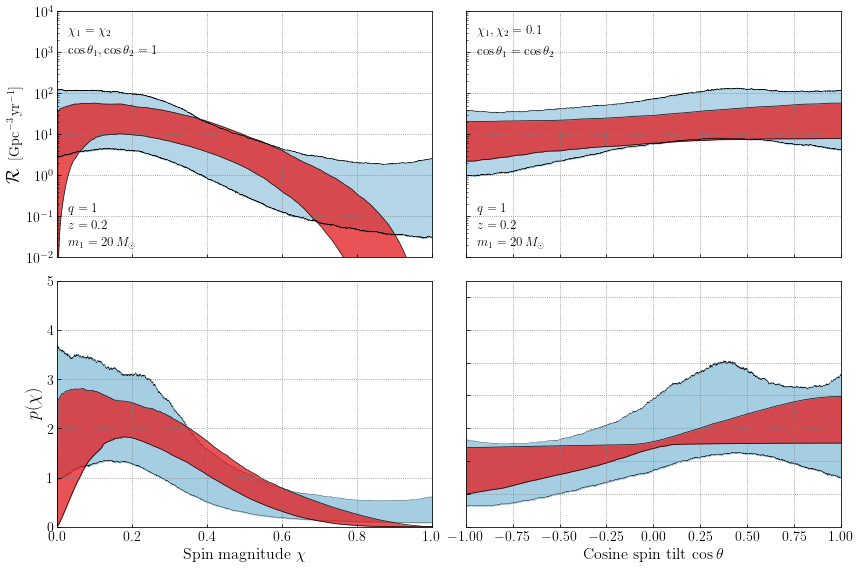

In [18]:
fig = plt.figure(figsize=(12,8))

#########################
ax = fig.add_subplot(221)
ax.set_rasterization_zorder(1)
    
#ax.plot(chis,np.median(dR_dchi_cost1,axis=0),color='black')
ax.plot(chis,np.quantile(dR_dchi_cost1,0.05,axis=0),color='black',lw=0.5)
ax.plot(chis,np.quantile(dR_dchi_cost1,0.95,axis=0),color='black',lw=0.5)
ax.fill_between(chis,
                np.quantile(dR_dchi_cost1,0.05,axis=0),
                np.quantile(dR_dchi_cost1,0.95,axis=0),
                color='#a6cee3',alpha=0.85,zorder=-1)

#ax.plot(lvk_chi_grid,np.mean(lvk_R_chi,axis=0),color='black',zorder=-2)
ax.plot(lvk_chi_grid,np.quantile(lvk_R_chi,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_chi_grid,np.quantile(lvk_R_chi,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_chi_grid,
                np.quantile(lvk_R_chi,0.05,axis=0),
                np.quantile(lvk_R_chi,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(1e-2,1e4)
ax.set_yscale('log')
ax.set_xticklabels([])

ax.text(0.03,0.92,r'$\chi_1 = \chi_2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.84,r'$\cos\theta_1,\cos\theta_2 = 1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.text(0.03,0.20,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.13,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

#########################
ax = fig.add_subplot(222)
ax.set_rasterization_zorder(1)

#ax.plot(costs,np.median(dR_dcost_a01,axis=0),color='black')
ax.plot(costs,np.quantile(dR_dcost_a01,0.05,axis=0),color='black',lw=0.5)
ax.plot(costs,np.quantile(dR_dcost_a01,0.95,axis=0),color='black',lw=0.5)
ax.fill_between(costs,
                np.quantile(dR_dcost_a01,0.05,axis=0),
                np.quantile(dR_dcost_a01,0.95,axis=0),
                color='#a6cee3',alpha=0.85,zorder=-1)

#ax.plot(lvk_cost_grid,np.mean(lvk_R_cost,axis=0),color='black',zorder=-2)
ax.plot(lvk_cost_grid,np.quantile(lvk_R_cost,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_cost_grid,np.quantile(lvk_R_cost,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_cost_grid,
                np.quantile(lvk_R_cost,0.05,axis=0),
                np.quantile(lvk_R_cost,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(1e-2,1e4)
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.text(0.03,0.92,r'$\chi_1,\chi_2=0.1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.84,r'$\cos\theta_1=\cos\theta_2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.text(0.03,0.20,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.13,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

#########################
ax = fig.add_subplot(223)
ax.set_rasterization_zorder(1)

#ax.plot(chis,np.median(p_chi,axis=0),color='black')
ax.plot(chis,np.quantile(p_chi,0.05,axis=0),color='black',lw=0.3,zorder=0)
ax.plot(chis,np.quantile(p_chi,0.95,axis=0),color='black',lw=0.2,zorder=0)
ax.fill_between(chis,
                np.quantile(p_chi,0.05,axis=0),
                np.quantile(p_chi,0.95,axis=0),
                color='#a6cee3',alpha=1,zorder=-1)

#ax.plot(lvk_chi_grid,np.mean(lvk_p_chis,axis=0),color='black',zorder=-2)
ax.plot(lvk_chi_grid,np.quantile(lvk_p_chis,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_chi_grid,np.quantile(lvk_p_chis,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_chi_grid,
                np.quantile(lvk_p_chis,0.05,axis=0),
                np.quantile(lvk_p_chis,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,5)

ax.set_xlabel('Spin magnitude $\chi$',fontsize=16)
ax.set_ylabel(r'$p(\chi)$',fontsize=18)

#########################
ax = fig.add_subplot(224)
ax.set_rasterization_zorder(1)

#ax.plot(costs,np.median(p_cost,axis=0),color='black')
ax.plot(costs,np.quantile(p_cost,0.05,axis=0),color='black',lw=0.3,zorder=0)
ax.plot(costs,np.quantile(p_cost,0.95,axis=0),color='black',lw=0.2,zorder=0)
ax.fill_between(costs,
                np.quantile(p_cost,0.05,axis=0),
                np.quantile(p_cost,0.95,axis=0),
                color='#a6cee3',alpha=1,zorder=-1)

#ax.plot(lvk_cost_grid,np.mean(lvk_p_costs,axis=0),color='black',zorder=-2)
ax.plot(lvk_cost_grid,np.quantile(lvk_p_costs,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_cost_grid,np.quantile(lvk_p_costs,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_cost_grid,
                np.quantile(lvk_p_costs,0.05,axis=0),
                np.quantile(lvk_p_costs,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1.5)
ax.set_yticklabels([])

ax.set_xlabel('Cosine spin tilt $\cos \\theta$',fontsize=16)

plt.tight_layout()
plt.savefig('chi_cost_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()